### Prediction of the average wage of Russians

import libraries and special functions

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


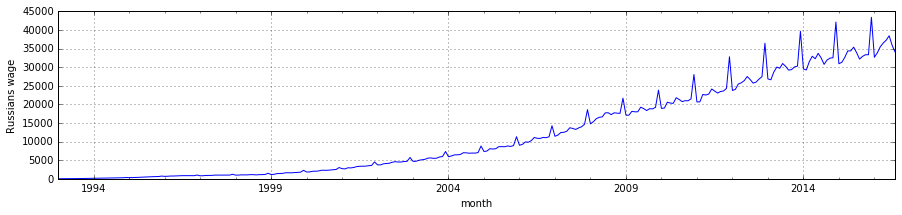

In [2]:
wage = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,3))
wage.WAG_C_M.plot()
plt.ylabel('Russians wage')
plt.grid(True)
pylab.show()

Check stationary amd STL - decomposition of column:plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wine.sales).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wine.sales)[1])

Dickey–Fuller test: p=0.991850


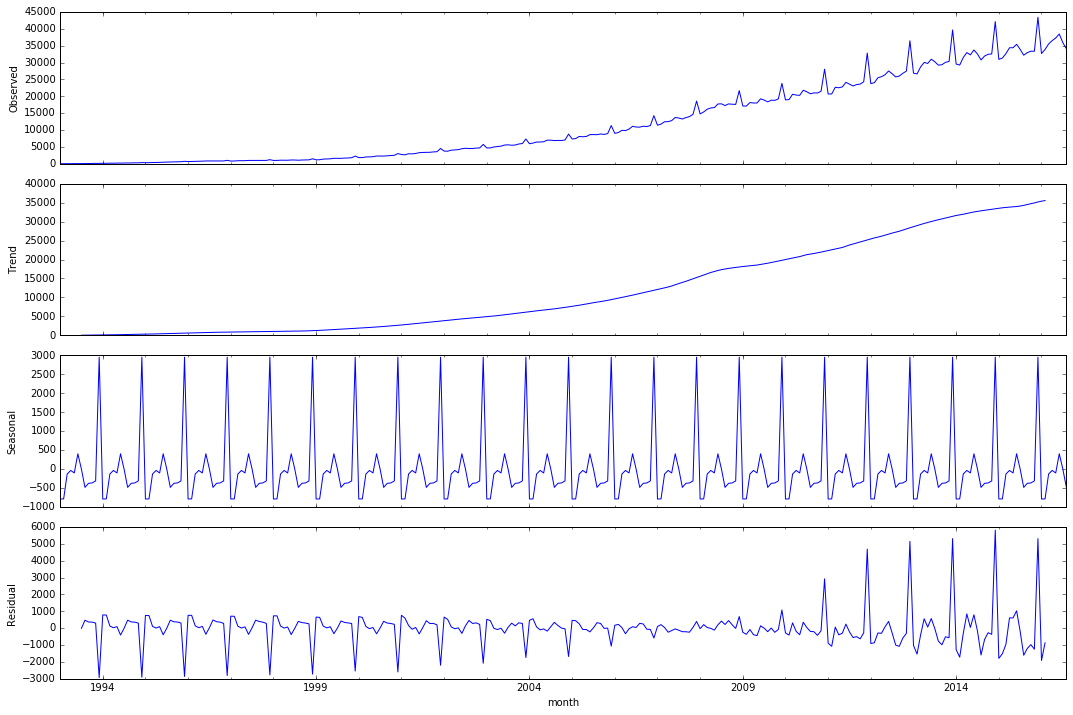

In [3]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.WAG_C_M).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(wage.WAG_C_M)[1])

###  Stabilisation variance

Box-Cox transform for variance stabilisation read more (https://en.wikipedia.org/wiki/Power_transform)

The Box-Cox transform optimum value: 0.263202
Dickey–Fuller test: p=0.696899


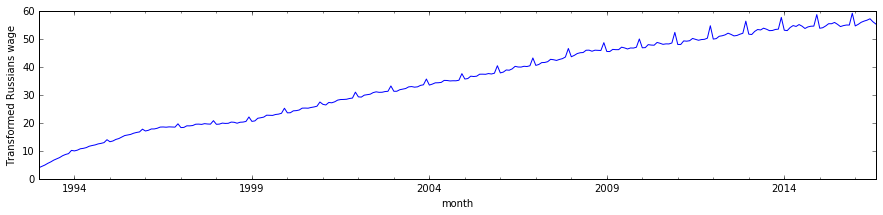

In [4]:
wage['wage_boxcox'], lmbda = stats.boxcox(wage.WAG_C_M)
plt.figure(figsize(15,3))
wage.wage_boxcox.plot()
plt.ylabel(u'Transformed Russians wage')
print ("The Box-Cox transform optimum value: %f" % lmbda)
print ("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(wage.wage_boxcox)[1])

the Box-Cox not resulted for transformed data to stationary form

Dickey–Fuller test: p=0.014697


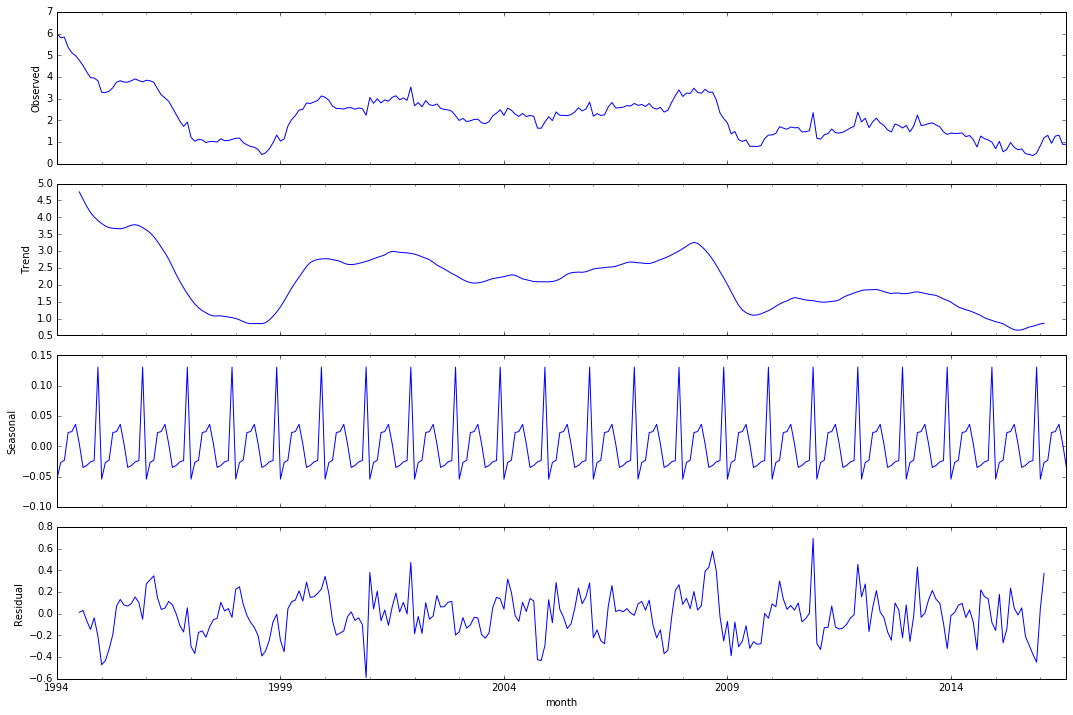

In [5]:
wage['wage_box_diff12'] = wage.wage_boxcox - wage.wage_boxcox.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.wage_box_diff12[~wage.wage_box_diff12.isnull()]).plot()   
print ("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(wage.wage_box_diff12[~wage.wage_box_diff12.isnull()])[1])

Dickey–Fuller test denise the hypothesis of nonstationary, but we can to see trend line.

Dickey–Fuller test: p=0.000000


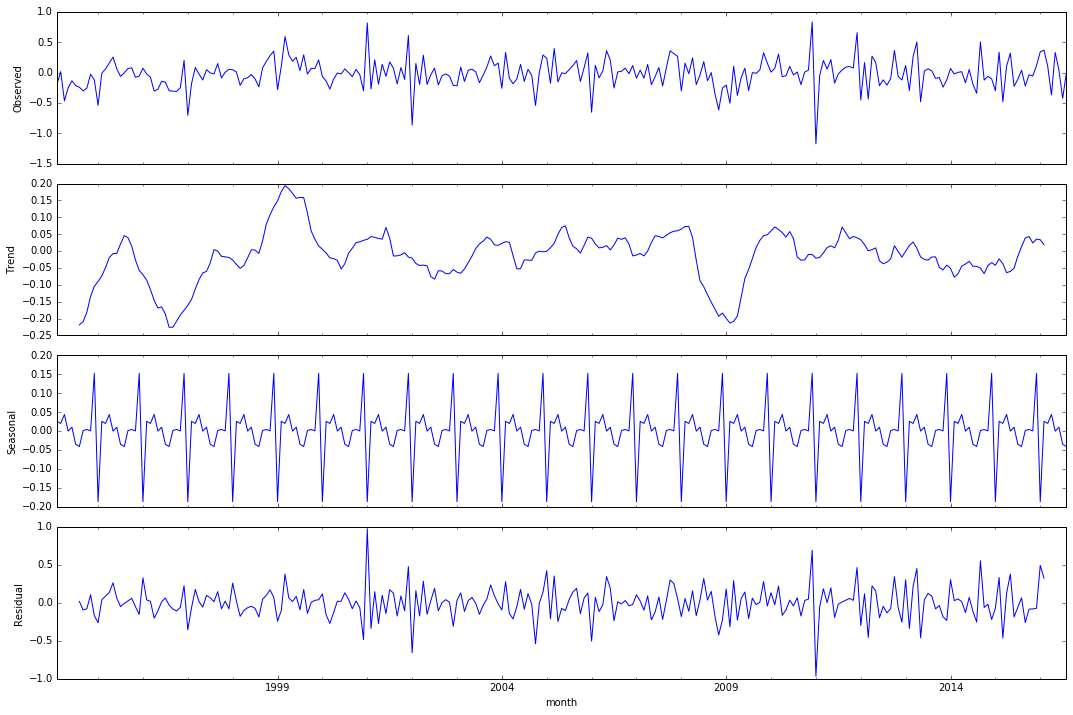

In [6]:
wage['wage_box_diff12_1'] = wage.wage_box_diff12 - wage.wage_box_diff12.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.wage_box_diff12_1[~wage.wage_box_diff12_1.isnull()]).plot()   
print ("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(wage.wage_box_diff12_1[~wage.wage_box_diff12_1.isnull()])[1])

Dickey–Fuller test denise the hypothesis of nonstationary, and we can't to see trend line.

## Selection models

review ACF and PACF from column:

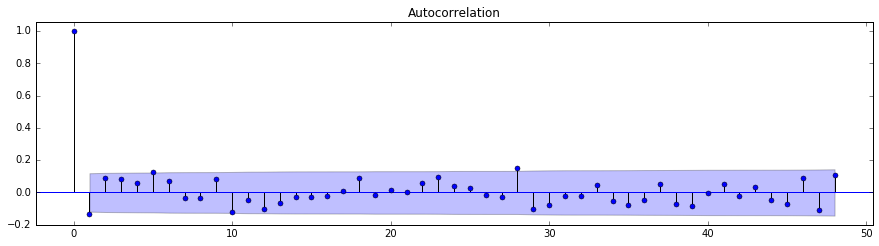

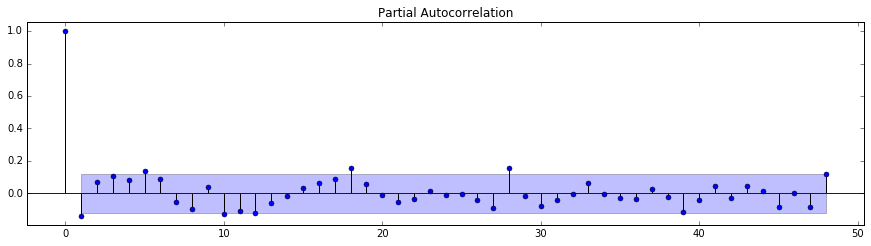

In [7]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wage.wage_box_diff12_1[~wage.wage_box_diff12_1.isnull()].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wage.wage_box_diff12_1[~wage.wage_box_diff12_1.isnull()].values.squeeze(), lags=48, ax=ax)
pylab.show()

Start aproximations: Q = 1, q = 1, P = 1, p = 1

Начальное приближение для Q нам дает номер последнего сезонного лага, при котором автокорреляция значима. В данном случае даже при наименьшем сезонном лаге (12 месяцев, т.е. первый сезонный период), мы видим, что автокорреляция находится ниже уровня значимости. Однако набор параметров для перебора у нас получится небольшой, и мы решаем сразу расширить его. Поэтому начальное приближение для Q возьмем равным 1.
Что касается q, его задает номер последнего несезонного лага, при котором автокорреляция значима. В данном случае в качестве начального приближения для q можно взять 1. 
Начальное приближение для P нам задает номер последнего сезонного лага, при котором частичная автокорреляция значима. Для второго сезонного лага (24 месяца) мы видим, что частичная автокорреляция незначима. Поэтому возьмем в качестве начального приближения P возьмем 1.
И наконец, параметр p задается как номер последнего несезонного лага, при котором частичная автокорреляция значима. В нашем случае - 1.
Итак, начальные приближения: Q=1, q=1, P=1, p=1

In [8]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [9]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [10]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except is need, because any results must be exclude
    try:
        model=sm.tsa.statespace.SARIMAX(wage.wage_boxcox, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #print excluded parameters and go to next row
    except ValueError:
        print ('wrong parameters:', param)
        continue
    aic = model.aic
    #save best, aic, parametres
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
Wall time: 5.9 s


In [11]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print result_table.sort_values(by = 'aic', ascending=True).head()

      parameters       aic
9   (1, 0, 1, 0)  0.340521
10  (1, 0, 1, 1)  0.492412
8   (1, 0, 0, 1)  0.774438
5   (0, 1, 1, 0)  1.170768
6   (0, 1, 1, 1)  1.342395


In [12]:
print best_model.summary()

                                 Statespace Model Results                                 
Dep. Variable:                        wage_boxcox   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Thu, 29 Sep 2016   AIC                              0.341
Time:                                    08:54:29   BIC                             11.287
Sample:                                01-01-1993   HQIC                             4.729
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

Stydent: p=0.090792
Dickey-Fuler: p=0.000007


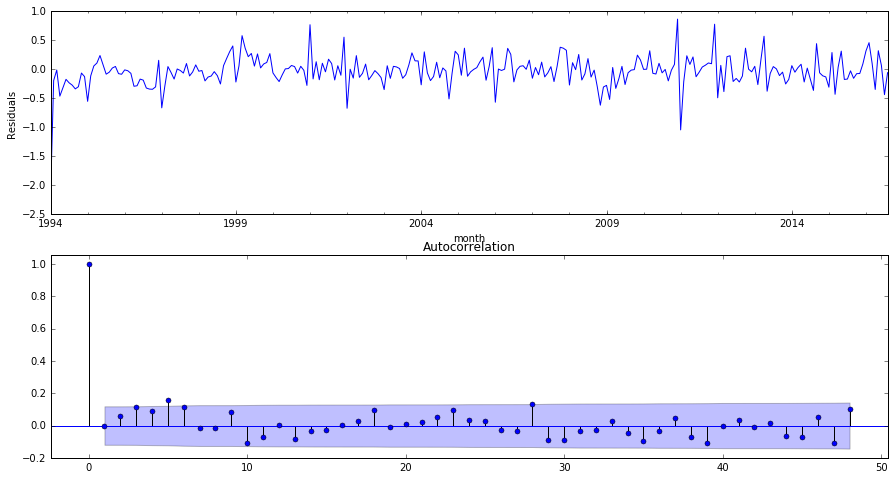

In [16]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[12:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print "Stydent: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1]
print "Dickey-Fuler: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[12:])[1]

The Stydent's test confirmed hypotesys about non-shifting tailings (but visual test demonstrated existence trand line, we can to exclude this period from the calculatiuons), 
and Dickey-Fulleer test confirmed hypotesys about.

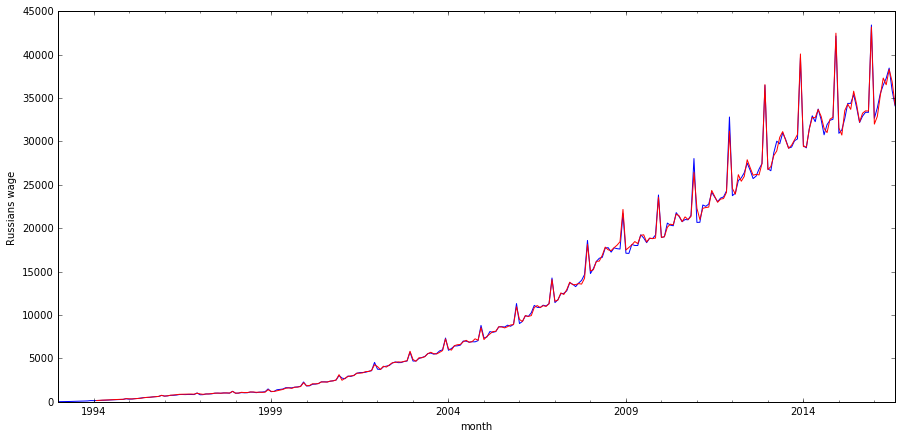

In [19]:
wage['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
wage.WAG_C_M.plot()
wage.model[13:].plot(color='r')
plt.ylabel('Russians wage')
pylab.show()

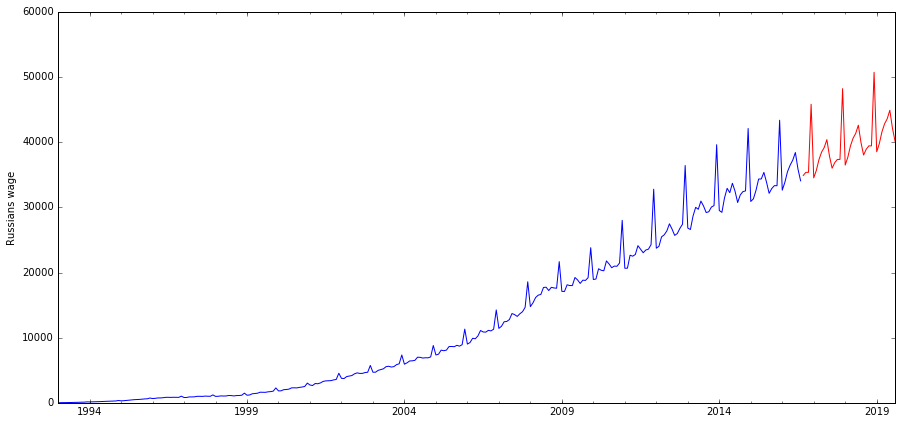

In [43]:
wage2 = wage[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns=wage2.columns)
wage2 = pd.concat([wage2, future])
wage2['forecast'] = invboxcox(best_model.predict(start=284, end=320), lmbda)

plt.figure(figsize(15,7))
wage2.WAG_C_M.plot()
wage2.forecast.plot(color='r')
plt.ylabel('Russians wage')
pylab.show()